<a href="https://colab.research.google.com/github/coldsober-irene/ASSIGNMENTS/blob/main/FullHAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2

import math
import random
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from moviepy.editor import *
from collections import deque
from keras.models import Sequential
from matplotlib import pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, ConvLSTM2D, Dropout
%matplotlib inline

##combined codes

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# import cv2

# import math
# import random
# import numpy as np
# import pandas as pd
# import datetime as dt
# import tensorflow as tf
# from tensorflow import keras
# from moviepy.editor import *
# from collections import deque
# from keras.models import Sequential
# from matplotlib import pyplot as plt
# from tensorflow.keras.layers import *
# from tensorflow.keras import layers, models
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.applications import ResNet50
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.metrics import accuracy_score, classification_report
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, ConvLSTM2D, Dropout
# %matplotlib inline

samples = 20
rate = 7

class Sampling:
  count = 0
  def __init__(self, video_path, map_file, sampling_type = 'uniform', val_sampling = False,
               ref_mean=[0.07, 0.07, 0.07], ref_std=[0.1, 0.09, 0.08], enhance_img = False, **kwargs):
    """save_feature_dir: path for storing extracted features for future use"""
    self.data_path = video_path
    self.map_file = map_file
    self.sampling_type = sampling_type
    self.is_valSampling = val_sampling
    self.mean = ref_mean
    self.std = ref_std
    self.enhance_img = enhance_img
    # ALL FEATURES OBTAINED FROM ENTIRE DATASETS
    self.obtained_features = []
    self.labels = []

    # GETTING MAPPING
    self.maps = {}
    with open(self.map_file, 'r') as f:
      lines = f.readlines()
      for line in lines:
          parts = line.split()
          if self.is_valSampling:
            self.maps[parts[-1]] = int(parts[1])
          else:
            self.maps[parts[1]] = int(parts[0])
    print(f'mapping: {self.maps}')
    # SAMPLERS
    self.TrainD_sampler = self.Sampling_Training(data_path = self.data_path,
                                                 mapping = self.maps,
                                                 labels_list = self.labels)
    self.ValidationD_sampler = self.Sampling_Validation(data_path = self.data_path,
                                                        mapping = self.maps,
                                                labels_list = self.labels )

    # FRAME SAMPLING
    if val_sampling:
      self.ValidationD_sampler.Sample(sampling_processor = self.sample)
    else:
      self.TrainD_sampler.Sample(sampling_processor = self.sample)


    # SAVE EXTRACTED FEATURE INTO THE FILE FOR FUTURE USE
    self.saveFeatures(destination_dir = kwargs['save_feature_dir'])
    print("EXTRACTED FEATURE ARE SAVED SUCCESSFULLY!")

  def UniformSampling(self, cap, sample_rate, frameCount):
    for i in range(0, frameCount, sample_rate):
      cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()
      if ret:
        if self.enhance_img:
          return self.enhance_image(input_frame = frame)
        return frame

  def RandomSampling(self, cap,num_samples, frameCount):
    sampled_indices = random.sample(range(frameCount), num_samples)
    # ORIGINAL VS ENHANCED FRAME
    frames_sampled_forPlot = {}
    for i in sampled_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        frames_sampled_forPlot['original frame'] = frame
        if ret:
          if self.enhance_img:
            enhanced = self.enhance_image(input_frame = frame)
            frames_sampled_forPlot['enhanced frame'] = enhanced
            x = lambda: display_frames(frames = frames_sampled_forPlot, title = 'Original frame vs Enhanced frame')
            x()
            return enhanced
          return frame

  def sample(self, cap, **kwargs):
    # CREATE EXTRACTOR OBJECT
    Extractor = Feature_extract(sampled_type = self.sampling_type)
    Sampling.count += 1
    if self.sampling_type == 'uniform':
      sample_frame = self.UniformSampling(cap = cap, frameCount=kwargs['frame_count'], sample_rate = kwargs['sample_rate'])
      kwargs['frames_sampled'].append(sample_frame)

    elif self.sampling_type == 'random':
      sample_frame = self.RandomSampling(cap = cap, frameCount=kwargs['frame_count'], num_samples=kwargs['num_samples'])
      kwargs['frames_sampled'].append(sample_frame)

    # EXTRACT FEATURE FROM THE FRAMES OF EACH VIDEO
    features_obtained = Extractor.features(frames = kwargs['frames_sampled'], ref_mean = self.mean, ref_std = self.std)
    self.obtained_features.append(features_obtained)
    print('Constructor created!')

  def enhance_image(self, input_frame, gamma=0.35, kernel_size=3):
    # Apply gamma correction
    gamma_corrected = np.power(input_frame / 255.0, gamma) * 255.0
    gamma_corrected = gamma_corrected.astype(np.uint8)

    # Return the gamma_corrected image
    return gamma_corrected
    print("FEATURE EXTRACTION AND SAVING IS DONE!!!")

  def saveFeatures(self, destination_dir):
    # CREATE VSTACK ARRAY OF ALL FEATURES EXTRACTED
    all_features = np.vstack(self.obtained_features)
    labels = np.array(self.labels)

    # SAVED THE EXTRACTED FEATURES and their corresponding labels FOR FUTURE USE
    os.makedirs(destination_dir, exist_ok = True)

    np.save(os.path.join(destination_dir,f'features{Sampling.count}.npy'), all_features)
    np.save(os.path.join(destination_dir,f'labels{Sampling.count}.npy'), labels)


  class Sampling_Training:
    def __init__(self, data_path, mapping:dict, labels_list:list = None):
      self.data_path = data_path
      self.maps = mapping
      # subfolders
      self.activities = os.listdir(self.data_path)
      # EXTRACTED FEATURES FROM ALL THE VIDEOS
      self.obtained_features = []
      # LABELS OF THE EXTRACTED FEATURES
      self.labels_list = labels_list

    def Sample(self,sampling_processor, sample_rate = 5, num_samples = 10):
      # Loop through each activity
      for activity in self.activities:
          activity_folder = os.path.join(self.data_path, activity)

          # Loop through video files in the activity folder
          for video_file in os.listdir(activity_folder):
            if '.mp4' in video_file:
              frames_sampled = []
              video_path = os.path.join(activity_folder, video_file)
              cap = cv2.VideoCapture(video_path)

              frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

              # PROCESSOR FOR FINISHING THE TASK
              sampling_processor(cap = cap, frame_count = frame_count,
                  sample_rate = sample_rate, frames_sampled = frames_sampled
                                 , num_samples = num_samples)
              # POPULATE THE LABEL CORRESPONDING TO THE CURRENT VIDEO
              if self.labels_list:
                self.labels_list.append(self.maps[activity])

  class Sampling_Validation:
    def __init__(self, data_path,mapping:dict, labels_list:list = None):
      self.data_path = data_path
      self.maps = mapping
      self.labels_list = labels_list

    def Sample(self, sampling_processor, sample_rate = 5, num_samples = 10):
      'sampling_processor: object to make sampling'
      # Loop through video files in the activity folder
      for video_file in os.listdir(self.data_path):
        if '.mp4' in video_file:
          frames_sampled = []
          video_path = os.path.join(self.data_path, video_file)
          cap = cv2.VideoCapture(video_path)

          frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

          # PROCESSOR FOR FINISHING THE TASK
          sampling_processor(cap = cap, frame_count = frame_count,
            sample_rate = sample_rate, frames_sampled = frames_sampled,
                             num_samples = num_samples)
          # POPULATE THE LABEL CORRESPONDING TO THE CURRENT VIDEO
          self.labels_list.append(self.maps[video_file])

class Feature_extract:
  def __init__(self, sampled_type = 'uniform'):
    # Load pre-trained ResNet50
    self.model = ResNet50(weights='imagenet', include_top=False)
    self.sampled_type = sampled_type

  # Function to normalize a frame
  def normalize_frame(self, frame, ref_mean, ref_std):
      actual_mean = np.mean(frame, axis=(0, 1), keepdims=True)
      actual_std = np.std(frame, axis=(0, 1))
      normalized_frame = (frame - actual_mean) / actual_std * ref_std + ref_mean
      return normalized_frame

  # Function to preprocess frames and extract features using ResNet
  def features(self,frames, ref_mean, ref_std):
      processed_frames = [self.normalize_frame(frame, ref_mean, ref_std) for frame in frames]
      processed_frames = [preprocess_input(frame) for frame in processed_frames]
      features = self.model.predict(np.array(processed_frames))
      print(f"frame: {features.shape}")
      return features

class Train_model:
  def __init__(self, valid_features_dir, train_features_dir, feaures_base_names = [], labels_base_name = [], **kwargs):
    '''kwargs: [val_size ex: 0.2, num_classes: classes of dataset, epoch ex : 200, patience: ex: 10, model_storage_dir: dir to hold trained model]'''
    self.trainFeatures = os.path.join(train_features_dir, feaures_base_names[0])
    self.valFeatures = os.path.join(valid_features_dir, feaures_base_names[1])
    self.trainLabels = os.path.join(train_features_dir, labels_base_name[0])
    self.valLabels = os.path.join(valid_features_dir, labels_base_name[1])
    self.X_train = np.load(self.trainFeatures, allow_pickle = True)
    self.y_train = np.load(self.trainLabels, allow_pickle = True)
    self.X_val = np.load(self.valFeatures, allow_pickle = True)
    self.y_val = np.load(self.valLabels, allow_pickle = True)

    self.kwargs = kwargs
    self.val_size = self.kwargs['val_size'] # 0.64
    self.shuffle = True
    self.num_classes = self.kwargs['num_classes'] #6
    self.epoch = self.kwargs['epoch'] #300
    self.patience = self.kwargs['patience'] # 10
    self.early_stopping = EarlyStopping(monitor='val_loss', patience= self.patience)

    features = np.vstack([self.X_train, self.X_val])
    labels = np.hstack([self.y_train, self.y_val])
    # print(labels.shape)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(features, labels, test_size=self.val_size,
                                                                          shuffle = self.shuffle, random_state=42)
    # DIR FOR MODEL
    # BASE_DIR ='/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/models'
    os.makedirs(kwargs['model_storage_dir'], exist_ok = True)

  def trainModel(self, model_savename = 'uniform_model'):
    # Define the model with 3D convolutional layers
    model = keras.Sequential([
        layers.Input(shape=self.X_train.shape[1:]),  # Input shape matches your feature shape
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(self.num_classes, activation='softmax')  # Output layer with the number of classes
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    modelHistory = model.fit(self.X_train, self.y_train, epochs=self.epoch, validation_data=(self.X_val, self.y_val)) # , callbacks=[early_stopping]
    plotting(modelHistory)
    model.save(os.path.join(self.kwargs['model_storage_dir'],f'{model_savename}.h5'))

    # PLOTTING
    x = lambda : plotting(modelHistory)
    x()

  def End2End(self):
    # Define the 2D CNN + LSTM model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'), input_shape=(self.X_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(6, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(self.X_train, self.y_train, epochs=10, validation_data=(self.X_val, self.y_val))

    # Evaluate the model
    accuracy = model.evaluate(self.X_val, self.y_val)[1]
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

  def model_evaluation(self, val_features, val_labels, model_name):
    results = {}
    X_val = np.load(val_features, allow_pickle = True)
    y_val = np.load(val_labels, allow_pickle = True)
    BASE_DIR = self.kwargs['model_storage_dir']
    models = os.listdir(BASE_DIR)
    # Load your saved model
    model = keras.models.load_model(os.path.join(BASE_DIR, f'{model_name}.h5'))
    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(X_val, y_val)

    # Print the evaluation results

    print("enhanced images sample")
    print("-"*100)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    results['test'] = (test_loss, test_accuracy)
    # RESULTS DATAFRAME
    result_df = pd.DataFrame(results)
    print(result_df)
    return result_df.to_latex(index=False)

def plotting(model):
  # Access training history
  training_accuracy = model.history['accuracy']
  validation_accuracy = model.history['val_accuracy']
  training_loss = model.history['loss']
  validation_loss = model.history['val_loss']
  # Plot the training and validation accuracy
  plt.figure(figsize=(10, 6))
  plt.plot(training_accuracy, label='Training Accuracy')
  plt.plot(validation_accuracy, label='Validation Accuracy')
  plt.plot(training_loss, label='Training loss')
  plt.plot(validation_loss, label='Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation')
  plt.legend()
  plt.grid(True)
  plt.show()

def display_frames(frames, title):
    num_frames = len(frames)
    fig, axs = plt.subplots(1, num_frames, figsize=(15, 3))

    for ax, (i, frame) in zip(axs, frames.items()):
        ax.imshow(frame)
        ax.axis('off')
        ax.set_title(f'{i}')

    # Adjust layout to minimize space between subplots
    plt.tight_layout()

    plt.show()




#object construction

In [ ]:
map_file = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate.txt'
samp = Sampling(video_path = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/train',
                map_file = map_file,
                sampling_type='random',
                val_sampling = False,
                ref_mean=[0.07, 0.07, 0.07],
                ref_std=[0.1, 0.09, 0.08],
                save_feature_dir = '/content/drive/MyDrive/dummy',enhance_img = True)



In [ ]:
valid_features_dir = '/content/drive/MyDrive/dummy'
train_features_dir = '/content/drive/MyDrive/dummy'
feaures_base_names = ['features1.npy','features2.npy']
labels_base_name = ['labels1.npy','labels2.npy']
classifier = Train_model(valid_features_dir, train_features_dir,
                         feaures_base_names, labels_base_name,
                         val_size = 0.2,
                         num_classes = 6,
                         epoch = 10,
                         patience = 10,
                         model_storage_dir = '/content/drive/MyDrive/docx')
classifier.trainModel(model_savename = 'mode')

#end-to-end

FEATURES SIZE: 150
LABELS SIZE: 150
SIZES: (150, 150)
SIZES 2: (120, 120, 30, 30)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                   

  saving_api.save_model(



EVALUATION PERFORMANCE: 1.07354116439819340.7666666507720947


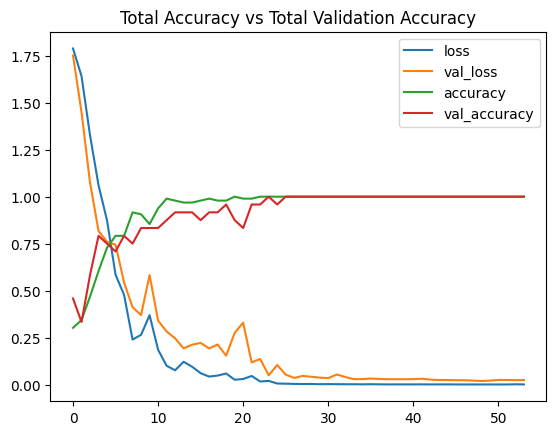

In [3]:
class End2End:
  def __init__(self, epochs = 25):
    self.seed = 27
    np.random.seed(self.seed)
    random.seed(self.seed)
    tf.random.set_seed(self.seed)
    self.img_h , self.img_w = 64, 64

    self.sizeOfSequence = 20
    self.dir = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/train'
    self.classes_to_predict = ["Jump", "Run", "Sit", "Stand", 'Walk', 'Turn']

    # DATASETS
    self.features, self.labels = self.prepareDataset()
    self.encoded_labels = to_categorical(self.labels)

    # Split the Data
    print(f"SIZES: {len(self.features), len(self.encoded_labels)}")
    # (120, 30, 120, 30)
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.features, self.encoded_labels,
                                                                                test_size = 0.2, shuffle = True,
                                                                                random_state = self.seed)
    print(f"SIZES 2: {len(self.x_train), len(self.y_train), len(self.x_test), len(self.y_test)}")
    # CREATED MODEL
    self.model = self.Model(sizeOfSequence = self.sizeOfSequence, classes = self.classes_to_predict,
                            img_h = self.img_h, img_w = self.img_w
                            , x_train = self.x_train, y_train = self.y_train,
                            x_test = self.x_test, y_test = self.y_test, epochs=epochs) # , epochs = 25, batch = 4, patience = 8


  def Sampling(self, video_path):
    frames_collected = []
    videoloader = cv2.VideoCapture(video_path)
    video_frames_count = int(videoloader.get(cv2.CAP_PROP_FRAME_COUNT))

    # interval after which frames will be taken
    skip_frames_window = max(int(video_frames_count/self.sizeOfSequence), 1)
    for frame_counter in range(self.sizeOfSequence):
        videoloader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        rec, frame = videoloader.read()
        if not rec:
            break

        # fixed height and width.
        resized_frame = cv2.resize(frame, (self.img_h, self.img_w))
        normalized_frame = resized_frame / 255

        frames_collected.append(normalized_frame)

    videoloader.release()
    return frames_collected

  def prepareDataset(self):
      features = []
      labels = []

      for index_in_class, class_ in enumerate(self.classes_to_predict):
          files = os.listdir(os.path.join(self.dir, class_))
          for file in files:
              video = os.path.join(self.dir, class_, file)
              frames = self.Sampling(video)

              if len(frames) == self.sizeOfSequence:
                  features.append(frames)
                  labels.append(index_in_class)

      # list to numpy arrays
      print(f"FEATURES SIZE: {len(features)}")
      print(f"LABELS SIZE: {len(labels)}")
      features = np.asarray(features)
      labels = np.array(labels)

      return features, labels

  class Model:
    def __init__(self, sizeOfSequence,classes, img_h, img_w, x_train, y_train, x_test, y_test, epochs = 25, batch = 4, patience = 8):
      self.sizeOfSequence = sizeOfSequence
      self.img_h = img_h
      self.img_w = img_w
      self.classes_to_predict = classes
      self.x_train, self.y_train, self.epochs, self.batch, self.patience = x_train, y_train, epochs, batch, patience
      self.x_test, self.y_test = x_test, y_test
      # CREATE MODEL
      self.model_created = self.ConvLSTM_Model()
      print('MODEL CREATED')

      # Plot contructed model.
      plot_model(self.model_created, to_file = 'model_structure.png', show_shapes = True, show_layer_names = True)
      early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)
      self.model_created.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

      # train the model.
      convlstm_history = self.model_created.fit(x = self.x_train, y = self.y_train, epochs = self.epochs, batch_size = self.batch,
                                                          shuffle = True, validation_split = 0.2,
                                                          callbacks = [early_stopping_callback])

      # Evaluate the trained model.
      model_evaluation = self.model_created.evaluate(self.x_test, self.y_test)
      evaluation_loss, evaluation_accuracy = model_evaluation
      print("EVALUATION PERFORMANCE: {}{}".format(evaluation_loss, evaluation_accuracy))
      model_file = f'convlstm_model_{evaluation_loss}_{evaluation_accuracy}.h5'
      # Save your Model.
      self.model_created.save(model_file)

      # Visualize the training and validation loss metrices.
      self.display_performance(convlstm_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
      self.display_performance(convlstm_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

    def ConvLSTM_Model(self):
        model = Sequential()

        model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                            recurrent_dropout=0.2, return_sequences=True, input_shape = (self.sizeOfSequence,
                                                                                          self.img_h, self.img_w, 3)))

        model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
        model.add(TimeDistributed(Dropout(0.2)))

        model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                            recurrent_dropout=0.2, return_sequences=True))

        model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
        model.add(TimeDistributed(Dropout(0.2)))

        model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                            recurrent_dropout=0.2, return_sequences=True))

        model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
        model.add(TimeDistributed(Dropout(0.2)))

        model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                            recurrent_dropout=0.2, return_sequences=True))

        model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

        model.add(Flatten())

        model.add(Dense(len(self.classes_to_predict), activation = "softmax"))
        model.summary()
        return model

    def display_performance(self, model_history, metric_1, metric_2, figName):
      value_ofMetric1 = model_history.history[metric_1]
      value_ofMetric2 = model_history.history[metric_2]

      epochs = range(len(value_ofMetric1))

      # Plot the Graph.
      plt.plot(epochs, value_ofMetric1, label = metric_1)
      plt.plot(epochs, value_ofMetric2, label = metric_2)
      plt.title(str(figName))
      plt.legend()


Run_end2end = End2End(epochs = 75)


#*part* 2: not submitted in the assignment

In [ ]:
## PART 2
# Implement the LRCN Approach
def LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (self.sizeOfSequence, self.img_h, self.img_w, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(self.classes_to_predict), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

# Construct the required LRCN model.
LRCN_model = LRCN_model()

# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_structure.png', show_shapes = True, show_layer_names = True)


# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


# Evaluate the trained model.
model_evaluation = LRCN_model.evaluate(features_test, labels_test)


# Get the loss and accuracy from model_evaluation.
evaluation_loss, evaluation_accuracy = model_evaluation
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file = f'LRCN_model_{evaluation_loss}_{evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file)


# Visualize the training and validation loss metrices.
display_performance(LRCN_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

# Visualize the training and validation accuracy metrices.
display_performance(LRCN_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Create a Function To Perform Action Recognition on Videos
input_video = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate/240.mp4'


def Predict_action(video, videoAfter_prediction, self.sizeOfSequence):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video:  The path of the video stored in the disk on which the action recognition is to be performed.
    videoAfter_prediction: The path where the ouput video with the predicted action being performed overlayed will be stored.
    self.sizeOfSequence:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    videoloader = cv2.VideoCapture(video)

    # Get the width and height of the video.
    vid_width = int(videoloader.get(cv2.CAP_PROP_FRAME_WIDTH))
    vid_height = int(videoloader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_object = cv2.VideoWriter(videoAfter_prediction, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   videoloader.get(cv2.CAP_PROP_FPS), (vid_width, vid_height))

    # Declare a queue to store video frames.
    frameSaver = deque(maxlen = self.sizeOfSequence)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_ = ''

    # Iterate until the video is accessed recfully.
    while videoloader.isOpened():

        # Read the frame.
        ok, frame = videoloader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (self.img_h, self.img_w))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frameSaver.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frameSaver) == self.sizeOfSequence:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frameSaver, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_ = self.classes_to_predict[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_object.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    videoloader.release()
    video_object.release()

# Construct the output video path.
output_video = f'Output_video{self.sizeOfSequence}.mp4'

# Perform Action Recognition on the Test Video.
Predict_action(input_video, output_video, self.sizeOfSequence)

# Display the output video.
VideoFileClip(output_video, audio=False, target_resolution=(300,None)).ipython_display()


def IfIsSingleVideo(video, self.sizeOfSequence):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video:  The path of the video stored in the disk on which the action recognition is to be performed.
    self.sizeOfSequence:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    videoloader = cv2.VideoCapture(video)

    # Get the width and height of the video.
    vid_width = int(videoloader.get(cv2.CAP_PROP_FRAME_WIDTH))
    vid_height = int(videoloader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_collected = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_ = ''

    # Get the number of frames in the video.
    video_frames_count = int(videoloader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/self.sizeOfSequence),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(self.sizeOfSequence):

        # Set the current frame position of the video.
        videoloader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        rec, frame = videoloader.read()

        # Check if frame is not read properly then break the loop.
        if not rec:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (self.img_h, self.img_w))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_collected.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_collected, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_ = self.classes_to_predict[predicted_label]

    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    # Release the VideoCapture object.
    videoloader.release()

# Perform Single Prediction on the Test Video.
IfIsSingleVideo(input_video, self.sizeOfSequence)

# Display the input video.
VideoFileClip(input_video, audio=False, target_resolution=(300,None)).ipython_display()